<a href="https://colab.research.google.com/github/thekaranacharya/tweet-sentiment-detection/blob/master/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Twitter Sentiment Analysis - A comparative study of LSTMs, GRUs & Conv1D layers in TensorFlow-Keras**

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


embedding_dim = 100
max_length = 64
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 160000

corpus = []

Download the dataset and load it in the runtime

In [2]:
import os

# downloading the cleaned dataset from Laurence Moroney's site
dataset_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv"
fname = os.path.join(os.getcwd(), "twitter-data.csv")
tf.keras.utils.get_file(fname, origin=dataset_url, extract=True)

'/content/twitter-data.csv'

Read the csv line by line and get the sentences (the actual tweet content) and the corresponding labels

In [3]:
num_sentences = 0
with open('/content/twitter-data.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    list_item = []
    list_item.append(row[-1])
    label = 0 if row[0] == '0' else 1
    list_item.append(label)
    num_sentences += 1
    corpus.append(list_item)


print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


We'll only use training_size (160,000) sentences and corresponding labels out of the 1.6M corpus

In [4]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

# Defining the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(word_index, "\n", vocab_size)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

training_portion = 0.9
train_split = int(training_portion * len(sentences))

training_padded = padded[: train_split]
training_labels = np.array(labels[: train_split])

val_padded = padded[train_split:]
val_labels = np.array(labels[train_split:])

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'is': 8, 'it': 9, 'for': 10, 'in': 11, 'of': 12, 'on': 13, 'me': 14, 'so': 15, 'have': 16, 'that': 17, 'but': 18, "i'm": 19, 'just': 20, 'with': 21, 'at': 22, 'be': 23, 'not': 24, 'was': 25, 'this': 26, 'now': 27, 'good': 28, 'up': 29, 'day': 30, 'out': 31, 'get': 32, 'all': 33, 'are': 34, 'like': 35, 'no': 36, 'go': 37, 'http': 38, 'quot': 39, 'today': 40, "it's": 41, 'do': 42, 'your': 43, 'work': 44, 'too': 45, 'going': 46, 'love': 47, 'got': 48, 'back': 49, 'lol': 50, 'time': 51, 'from': 52, 'u': 53, 'will': 54, 'one': 55, 'com': 56, 'what': 57, 'im': 58, 'know': 59, 'we': 60, 'am': 61, 'about': 62, 'amp': 63, 'really': 64, "don't": 65, 'had': 66, 'can': 67, "can't": 68, 'see': 69, 'some': 70, 'still': 71, 'if': 72, '2': 73, 'its': 74, 'well': 75, 'new': 76, 'how': 77, 'night': 78, 'want': 79, 'think': 80, 'home': 81, 'oh': 82, 'when': 83, 'thanks': 84, 'as': 85, 'there': 86, 'off': 87, 'miss': 88, 'more': 89, 'here': 

You might be wondering why we used the entire 'sentences' (160,000 tweets) on the Tokenizer's 'fit_on_texts' method. 
This is because we'll actually be using pre-trained Embeddings from GloVe(Transfer Learning).

When we transfer learn, we split the data *after* fitting on the corpus.

On the other hand,
when we are not using Transfer Learning, we fit the Tokenizer only on the training sentences.

In [5]:
print(len(padded), len(labels))
print(len(training_padded), len(training_labels))
print(len(val_padded), len(val_labels))

160000 160000
144000 144000
16000 16000


In [10]:
# Using GloVe Embeddings (Transfer Learning)

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {}

# get the word and the corresponding coefficients and add it to the dictionary 'embeddings_index'
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(len(embeddings_index.keys())) # check the length


# define a zero matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

# for each word from only the word_index(from the Tokenizer in the previous cell),
# add the coefficents (a vector) to the matrix
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

print(len(embeddings_matrix))

--2020-09-10 09:54:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.216.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   121MB/s    in 2.7s    

2020-09-10 09:54:14 (121 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

400000
138424


As you can see here, we are actually using only 138,424 (the vocab_size + 1) words from the total 400,000 in the GloVe version we downloaded!

**Model 0 : Only the Embedding layer**

In [11]:
training_labels = np.array(training_labels)
val_labels = np.array(val_labels)

model_0 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1,
                                output_dim=embedding_dim,
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           13842400  
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 13,843,217
Trainable params: 817
Non-trainable params: 13,842,400
_________________________________________________________________


In [13]:
history_0 = model_0.fit(training_padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/50
4500/4500 - 12s - loss: 0.6189 - accuracy: 0.6703 - val_loss: 0.5979 - val_accuracy: 0.6888
Epoch 2/50
4500/4500 - 12s - loss: 0.5908 - accuracy: 0.6969 - val_loss: 0.5910 - val_accuracy: 0.6958
Epoch 3/50
4500/4500 - 12s - loss: 0.5833 - accuracy: 0.7003 - val_loss: 0.5805 - val_accuracy: 0.7009
Epoch 4/50
4500/4500 - 12s - loss: 0.5753 - accuracy: 0.7033 - val_loss: 0.5744 - val_accuracy: 0.6978
Epoch 5/50
4500/4500 - 12s - loss: 0.5702 - accuracy: 0.7051 - val_loss: 0.5687 - val_accuracy: 0.7047
Epoch 6/50
4500/4500 - 12s - loss: 0.5669 - accuracy: 0.7067 - val_loss: 0.5662 - val_accuracy: 0.7034
Epoch 7/50
4500/4500 - 12s - loss: 0.5647 - accuracy: 0.7079 - val_loss: 0.5672 - val_accuracy: 0.6978
Epoch 8/50
4500/4500 - 12s - loss: 0.5635 - accuracy: 0.7082 - val_loss: 0.5624 - val_accuracy: 0.7072
Epoch 9/50
4500/4500 - 12s - loss: 0.5618 - accuracy: 0.7088 - val_loss: 0.5625 - val_accuracy: 0.7066
Epoch 10/50
4500/4500 - 12s - loss: 0.5608 - accuracy: 0.7096 - val_loss:

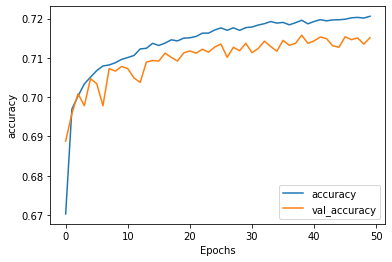

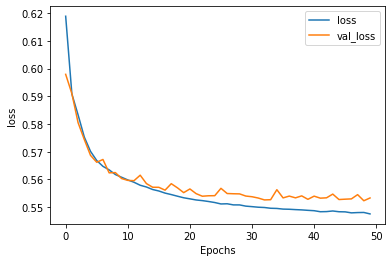

In [14]:
import matplotlib.pyplot as plt
def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.plot(hist.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history_0, "accuracy")
plot_graphs(history_0, "loss")

The validation loss is actually NOT increasing here, which means that there is *NO LOSS OF confidence* in the predictions over the course of the epochs.

**This is actually a good sign.**

But it is quite evident that both the training & validation accuracy are not great.

Now we'll try with LSTMs.

There's no point in trying with a unidirectional LSTM here.
This is because these are actual tweets and a Bidirectional is better suited to understand the context than a simple unidirectional one.

**Model 1 : Embedding with 1 Bidirectional LSTM**

In [ ]:
model_1 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

history_1 = model_1.fit(training_padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

We can always stack more Bidirectional LSTM layers on top of each other but **it won't really help our purpose**.

This is because, stacking more layers will actually engender overfitting. This will ensure that the training accuracy reaches > 97% but **the validation loss will now increase**.
i.e the confidence in validation predictions drop.

Let's see whether GRU's can help us.
(For the same reason cited above, we're not trying out unidirectional GRUs here)

**Model 2 : Embedding with 1 Bidirectional GRU**

In [ ]:
model_2 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

history_2 = model_2.fit(training_padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 64, 100)           13842400  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                11328     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 13,854,001
Trainable params: 11,601
Non-trainable params: 13,842,400
_________________________________________________________________
Epoch 1/50
4500/4500 - 135s - loss: 0.5371 - accuracy: 0.7257 - val_loss: 0.4982 - val_accuracy: 0.7559
Epoch 2/50


Let's now try with only 1 pair of Conv1D & MaxPooling1D layers.

**Model 3 : Embedding with 1 Conv1D and 1 MaxPooling1D layer**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 64, 100)           13842400  
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 64)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 15, 8)             520       
_________________________________________________________________
dense_5 (Dense)              (None, 15, 1)             9         
Total params: 13,874,993
Trainable params: 32,593
Non-trainable params: 13,842,400
_________________________________________________________________
Epoch 1/50
4500/4500 [==============================] - 18s 4ms/step - loss: 0.6759 - accuracy: 0.5363 

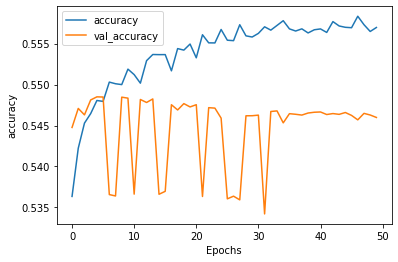

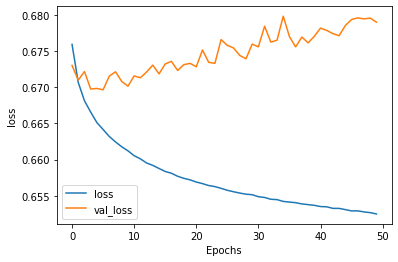

In [16]:
model_3 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Conv1D(64, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()

history_3 = model_3.fit(training_padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_3, "accuracy")
plot_graphs(history_3, "loss")

**Model 4: Embedding with 1 set of Conv1D & MaxPooling1D with 1 Bidirectional LSTM**

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 64, 100)           13842400  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 64)            32064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 13,941,553
Trainable params: 99,153
Non-trainable params: 13,842,400
_____________________________________

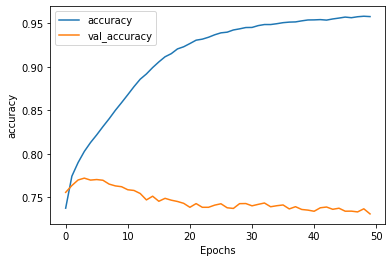

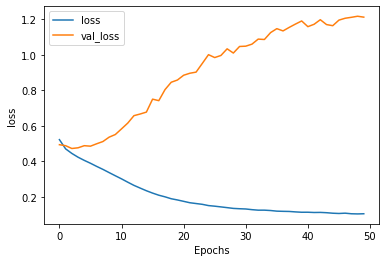

In [19]:
model_4 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Conv1D(64, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_4.summary()

history_4 = model_4.fit(training_padded, training_labels, epochs=50, validation_data=(val_padded, val_labels), verbose=2)

plot_graphs(history_4, "accuracy")
plot_graphs(history_4, "loss")

**Model 5: Embedding with Dropout, Conv1D, MaxPooling1D, 1 Bidirectional LSTM**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 64, 100)           13842400  
_________________________________________________________________
dropout (Dropout)            (None, 64, 100)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 64)            32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

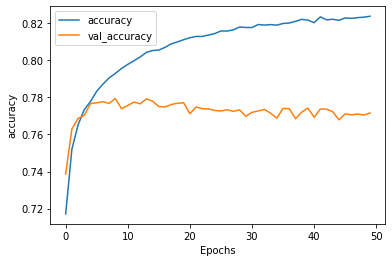

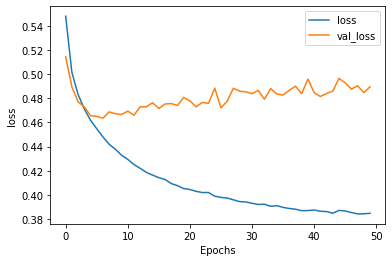

In [20]:
model_5 = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=vocab_size+1, 
                                output_dim=embedding_dim, 
                                input_length=max_length,
                                weights=[embeddings_matrix],
                                trainable=False),
      tf.keras.layers.Dropout(0.2),                         
      tf.keras.layers.Conv1D(64, 5, activation='relu'),
      tf.keras.layers.MaxPooling1D(pool_size=4),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_5.summary()

history_5 = model_5.fit(training_padded, training_labels, epochs=50, validation_data=(val_padded, val_labels))

plot_graphs(history_5, "accuracy")
plot_graphs(history_5, "loss")